<a href="https://colab.research.google.com/github/YinmiAlas/DS-Unit-2-Kaggle-Challenge/blob/master/LS_DS_224_ClassificationMetrics_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 2, Module 4*

---

# Classification Metrics

## Assignment
- [ ] If you haven't yet, [review requirements for your portfolio project](https://lambdaschool.github.io/ds/unit2), then submit your dataset.
- [ ] Plot a confusion matrix for your Tanzania Waterpumps model.
- [ ] Continue to participate in our Kaggle challenge. Every student should have made at least one submission that scores at least 70% accuracy (well above the majority class baseline).
- [ ] Submit your final predictions to our Kaggle competition. Optionally, go to **My Submissions**, and _"you may select up to 1 submission to be used to count towards your final leaderboard score."_
- [ ] Commit your notebook to your fork of the GitHub repo.
- [ ] Read [Maximizing Scarce Maintenance Resources with Data: Applying predictive modeling, precision at k, and clustering to optimize impact](http://archive.is/DelgE), by Lambda DS3 student Michael Brady. His blog post extends the Tanzania Waterpumps scenario, far beyond what's in the lecture notebook.


## Stretch Goals

### Reading

- [Attacking discrimination with smarter machine learning](https://research.google.com/bigpicture/attacking-discrimination-in-ml/), by Google Research, with  interactive visualizations. _"A threshold classifier essentially makes a yes/no decision, putting things in one category or another. We look at how these classifiers work, ways they can potentially be unfair, and how you might turn an unfair classifier into a fairer one. As an illustrative example, we focus on loan granting scenarios where a bank may grant or deny a loan based on a single, automatically computed number such as a credit score."_
- [Notebook about how to calculate expected value from a confusion matrix by treating it as a cost-benefit matrix](https://github.com/podopie/DAT18NYC/blob/master/classes/13-expected_value_cost_benefit_analysis.ipynb)
- [Visualizing Machine Learning Thresholds to Make Better Business Decisions](https://blog.insightdatascience.com/visualizing-machine-learning-thresholds-to-make-better-business-decisions-4ab07f823415)


### Doing
- [ ] Share visualizations in our Slack channel!
- [ ] RandomizedSearchCV / GridSearchCV, for model selection. (See module 3 assignment notebook)
- [ ] Stacking Ensemble. (See module 3 assignment notebook)
- [ ] More Categorical Encoding. (See module 2 assignment notebook)

In [38]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [39]:
import pandas as pd
import numpy as np
# Merge train_features.csv & train_labels.csv
train = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv'), 
                 pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv'))

# Read test_features.csv & sample_submission.csv
test = pd.read_csv(DATA_PATH+'waterpumps/test_features.csv')
sample_submission = pd.read_csv(DATA_PATH+'waterpumps/sample_submission.csv')

In [40]:
train.shape, test.shape

((59400, 41), (14358, 40))

In [41]:
from sklearn.model_selection import train_test_split
train, validation = train_test_split(train, test_size=len(test),  
                              stratify=train[target], random_state=42)
train.shape, validation.shape, test.shape

((45042, 41), (14358, 41), (14358, 40))

In [42]:
def wrangle(X):
    """Wrangle train, validate, and test sets in the same way"""
    
    # Prevent SettingWithCopyWarning
    X = X.copy()
    
    # About 3% of the time, latitude has small values near zero,
    # outside Tanzania, so we'll treat these values like zero.
    # Remove Null island (sometimes outliers will be coded as an extreme number)
    X['latitude'] = X['latitude'].replace(-2e-08, 0)
    
    # When columns have zeros and shouldn't, they are like null values.
    # So we will replace the zeros with nulls, and impute missing values later.
    # Also create a "missing indicator" column, because the fact that
    # values are missing may be a predictive signal.
    cols_with_zeros = ['longitude', 'latitude', 'construction_year', 
                       'gps_height', 'population', 'num_private']

    for col in cols_with_zeros:
        X[col] = X[col].replace(0, np.nan)
        X[col+'_MISSING'] = X[col].isnull()
            
    # Drop duplicate columns
    duplicates = ['quantity_group', 'payment_type', 'waterpoint_type_group', 'source_type', 'extraction_type_group']
    X = X.drop(columns=duplicates)
    
    # Drop column recorded_by because never varies and id always varies like random
    unusable_variance = ['recorded_by', 'id']
    X = X.drop(columns=unusable_variance)
    
    # Convert date_recorded to datetime
    X['date_recorded'] = pd.to_datetime(X['date_recorded'], infer_datetime_format=True)
    
    # Extract components from date_recorded, then drop the original column
    X['year_recorded'] = X['date_recorded'].dt.year
    X['month_recorded'] = X['date_recorded'].dt.month
    X['day_recorded'] = X['date_recorded'].dt.day
    X = X.drop(columns='date_recorded')
    
    # Engineer feature: how many years from construction_year to date_recorded
    X['years'] = X['year_recorded'] - X['construction_year']
    X['years_MISSING'] = X['years'].isnull()
    
    # return the wrangled dataframe
    return X

train1 = wrangle(train)
validation1 = wrangle(validation)
test1 = wrangle(test)

In [43]:
# The status_group column is the target
target = 'status_group'

# Get a dataframe with all train columns except the target
features = train1.drop(columns=[target])

# Get a list of the numeric features
numeric = features.select_dtypes(include='number').columns.tolist()

# Get a series with the cardinality of the nonnumeric features
cardinality = features.select_dtypes(exclude='number').nunique()

# Get a list of all categorical features with cardinality <= 50
categorical = cardinality[cardinality <= 25].index.tolist()

# Combine the lists 
final_features = numeric + categorical

In [45]:
#vectors and matrices
X_train = train1[final_features]
y_train = train1[target]
X_validation = validation1[final_features]
y_validation = validation1[target]
X_test = test1[final_features]

In [46]:
%matplotlib inline
from sklearn.metrics import accuracy_score
from sklearn.pipeline import make_pipeline
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt

pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median'), 
    RandomForestClassifier(n_estimators=100, random_state=50, n_jobs=-1)
  )

# Fit on train, score on val
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_validation)
print('Validation Accuracy', accuracy_score(y_validation, y_pred))

Validation Accuracy 0.8119515252820727


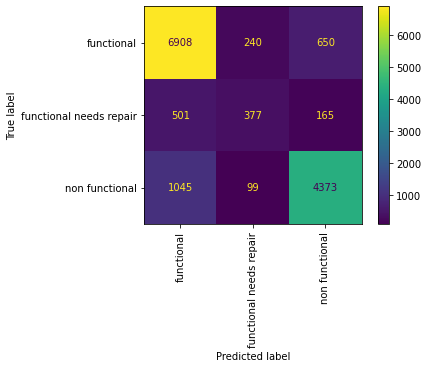

In [48]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(pipeline, X_validation, y_validation, values_format='.0f', xticks_rotation='vertical');

In [29]:
y_pred = pd.DataFrame(y_pred)
y_pred

,0
0,non functional
1,non functional
2,functional
3,functional
4,non functional
...,...
14353,non functional
14354,non functional
14355,functional
14356,functional needs repair


In [30]:
submission = sample_submission.copy()
submission['status_group'] = y_pred #<--This is for your test data
submission

,id,status_group
0,50785,non functional
1,51630,non functional
2,17168,functional
3,45559,functional
4,49871,non functional
...,...,...
14353,39307,non functional
14354,18990,non functional
14355,28749,functional
14356,33492,functional needs repair


In [31]:
submission.to_csv("Yinmi_Alas_finalclassification.csv", index = False)